#  Brim algorithm


This notebook looks at getting the BRIM algorithm working.

Briefly, there were two issues.  The most recent verison of the code on https://github.com/genisott/pycondor ([commit 84a1ba](https://github.com/genisott/pycondor/commit/84a1ba24f6ed9f12bed857d551e5c9f3d02f5cb4)) doesn't appear to work using the example data supplied.  My suspicion is that this is still a work in progress (though it isn't on a separate "branch" as you would normally expect)

Instead, I've worked with [commit 38993](https://github.com/genisott/pycondor/commit/389932cfa4d1954aef7d1b725a33a6b2ef018de2), from 28 August 2019.  This is the most last commit before a large gap in development (the next commit is on 26 December 2021), and is, I assume, the version Julia was using previously.   The contestent code will check that an appropriate version of pycondor is installed (this relies on the package interface changing, since there isn't a version string in the package)

The code has a somewhat unusual interface, taking a Pandas dataframe containing an edgelist.   This is then converted to an igraph object by the Condor object.  The effect of this is that the vertex and edge sequences in the internal Condor igraph are _different_ to the vertex and edge sequences of the igraph object that the user created the edgelist from (although the two graphs are equivalent).   (In practice, it would probably be preferable for the Condor algorithm to take an igraph object as its input, though this would require re-writing it)

This was the reason that very low values of the metrics were being returned; the community assignments being returned by Condor are in its order, but the performance metrics were being calculated with respect to the ground truth in _our_ order.




In [1]:
%load_ext autoreload
%autoreload 2

import igraph
from moo.data_generation import ExpConfig, DataGenerator
from moo.contestant import get_best_community_solutions, draw_best_community_solutions
from moo.communities import run_parallel_communities
import moo.contestant as contestant
import matplotlib.pyplot as plt

from joblib import Parallel, delayed


import pandas as pd

import time


In [2]:
expconfig = ExpConfig(
    L=100, U=100,
    NumEdges=1000, ML=0.5, MU=0.5,
    BC=0.2, NumGraphs=30,
    shuffle=True, 
    seed=1234  
    )


algos = [
    contestant.ComDetMultiLevel(), # Multi-Level approach
    contestant.ComDetEdgeBetweenness(), # EdgeBetweenness approach
    contestant.ComDetWalkTrap(), # WalkTrap approach
    contestant.ComDetFastGreedy(), # FastGreedy approach
    contestant.ComDetBRIM(), # Brim
]

expgen = DataGenerator(expconfig=expconfig) # Pass defined parameters


datagenParallel = expgen.generate_data() 

start = time.time()
parallelResults = run_parallel_communities(datagenParallel, algos, n_jobs = 7)

parallelTime = time.time()-start
print("Parallel time taken", parallelTime)

150it [00:47,  3.13it/s]


Parallel time taken 52.938499450683594


(-0.10473599917560124, 1.1)

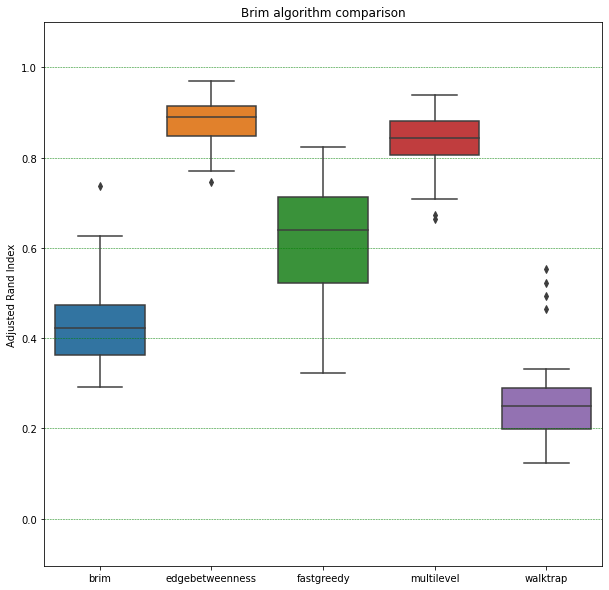

In [3]:
df = pd.DataFrame(parallelResults)

best_solutions = get_best_community_solutions(df) # Extract best solutions for each graph/algorithm pair
# Optional: Sort algorithms to match algorithm order in paper figures
# algo_order = {'walktrap':1, 'fastgreedy':2, 'edgebetweenness':3, 'multilevel':4, 'brim':5, 'multicriteria_3d':5, 'multicriteria_2d':6}
#algo_order = {'WT':1, 'FG':2, 'BRIM':3} # Define required order here
#best_solutions['algo_order'] = best_solutions.name.map(algo_order)
#best_solutions.sort_values(by=['algo_order'], axis=0, ascending=True, inplace=True, ignore_index=True
fig, ax = plt.subplots(figsize=(10,10))
ax, stats = draw_best_community_solutions(best_solutions, ax)
ax.set_title(f'Brim algorithm comparison')
ax.set_xlabel("")
ax.set_ylabel("Adjusted Rand Index")
ax.grid(axis='y', color = 'green', linestyle = '--', linewidth = 0.5)
min_y = min(df.adj_rand_index.min(), 0) -0.1 # Accounts for BRIM results
ax.set_ylim(min_y,1.1)